# Preprocessing and analysis for the 4-in-a-row model fits

In [1]:
import json
import re
import random
import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.stats as st
from numpy.polynomial.polynomial import polyfit
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

In [2]:
# Increase font size a bit
plt.rcParams.update({'font.size': 16})

## Preprocessing

In [2]:
# Open full filtered dataset
with open('../../../Peak/Code/peak-analysis/saved_analyses_updated/AI_filter.txt', 'r') as filehandle:  
    games_filtered = json.load(filehandle)

In [3]:
with open('../../../Peak/Code/peak-analysis/saved_analyses_updated/numgames_user.txt', 'r') as filehandle:  
    num_games = json.load(filehandle)

In [4]:
# Put all users with at least 20 games in a set
select_users = set()
for user in num_games:
    if num_games[user] == 20:
        select_users.add(user)
        
# Now create a dictionary with user IDs and each game path that corresponds to the user
select_dict = dict((el,[]) for el in select_users)

for game in games_filtered:
    ID = game[36:46]
    if ID in select_users:
        select_dict[ID].append(game)

In [5]:
# Pick a small subset of the users for fitting
user_sample = dict(random.sample(select_dict.items(), 100))
list(user_sample.keys())

['KbVxLgvqLV',
 'vJMzGyQqfD',
 'iofXRfyBWp',
 'CokTgtPoEy',
 'vLSxDpjQkD',
 'BMnczkFJwv',
 'VkjSrtLedv',
 'FrNdmCyLnV',
 'hQLfTDAFDf',
 'BplsuMjmHj',
 'MKwhSeTtWT',
 'JewmvMdaMi',
 'jGnAEgphcc',
 'DpcbMRdHZf',
 'OhkAyVsYsZ',
 'kFLjMOrAlv',
 'dzSPSQXkWo',
 'pexwLMQkIc',
 'NopEUidkpc',
 'PTguZBxgXK',
 'QrOaYJIRfX',
 'SkOyVWfxgA',
 'pIAJojyFPI',
 'QJFGbtvFga',
 'dLYIZnyUil',
 'tQlEmSAMXk',
 'yNxQnSsMhm',
 'XvpzSRZAmh',
 'OKLkkmsBlQ',
 'YViZscfWAu',
 'uapqqksJfH',
 'dpsPyjUISO',
 'ytGGtHNbeh',
 'DQmRfgoMXp',
 'hYtejLPjGe',
 'wIyHNcmqWC',
 'yvEkCDCGaG',
 'whnQBiPPPD',
 'lNSjiZCTmh',
 'QIkHiZRWfy',
 'MXyAPxgpSN',
 'cFZVmimBxV',
 'TsPBHqnfnr',
 'BZRBcvuClT',
 'OgWvrfvGwO',
 'fwyESZsUqu',
 'DSczsKrIjb',
 'PEQWttmgtX',
 'mVfyxWYkgV',
 'KPWaVkHQcA',
 'nXxZxNkDCQ',
 'phkbdzEWeO',
 'XkhAUCicjS',
 'rkwTRFulzM',
 'jaSiKGGNKI',
 'wEIYqYloar',
 'fpBGLNKnwK',
 'yuinbifyhB',
 'eUAftNkeee',
 'DLUIOUFfmV',
 'VjDgEPvdqm',
 'FoHgvPVDxa',
 'SOPBEctKRH',
 'ffSYKMJwrs',
 'ckFOxBgviN',
 'zPxyZkqIRj',
 'TOwlavjH

In [6]:
# Function to get all of the moves in a game and return them in a list
def get_moves_from_json(data):
    return [d['positionValue'] for d in data['data']['rounds'][-1]['analytic']['events'] if d['stateString']=='Turn']

In [7]:
# Function to get the total game length (number of moves + timed out moves) for a single game
def get_game_length(data):
    game_length = 0
    for i in data['data']['rounds'][-1]['analytic']['events']:
        if i['stateString'] == 'Turn':
            game_length +=1
    return game_length

In [8]:
# Function to return integer code for a list of moves
def encode_move_list(moves):
    return np.sum([2**m for m in moves])

In [9]:
# Loop through each game to get the info we need: board state, chosen move, response time, player ID for each move
for userID, path_list in user_sample.items():
    player = userID
    with open('raw/' + player + '.csv','w') as f1:
        writer=csv.writer(f1, delimiter='\t',lineterminator='\n',)
        for i in range(len(path_list)):
            game = path_list[i]
            with(open(game)) as f:
                data = json.load(f)

                # Get all moves in a list
                all_moves = get_moves_from_json(data)

                # Get game length
                game_length = get_game_length(data)

                # Loop through each turn, get info that's left, and write to a new line in the csv
                for turn in range(0,game_length,2):
                    if data['data']['rounds'][-1]['analytic']['events'][turn]['stateString'] == 'Pause':
                        print(player, data['data']['rounds'][turn]['analytic']['events'][turn])
                    elif data['data']['rounds'][-1]['analytic']['events'][turn]['stateString'] == 'Resume':
                        print(player, data['data']['rounds'][turn]['analytic']['events'][turn])
                    elif data['data']['rounds'][-1]['analytic']['events'][turn]['playerString'] == 'player':
                        response_time = data['data']['rounds'][turn]['duration']/1000
                        move = int(encode_move_list([all_moves[turn]]))
                        board_state = all_moves[:turn]
                        black_code = int(encode_move_list(board_state[::2]))
                        white_code = int(encode_move_list(board_state[1::2]))
                        writer.writerow([black_code,white_code,"Black",move,response_time,player])

vJMzGyQqfD {'stateString': 'Pause'}
iofXRfyBWp {'stateString': 'Pause'}
FrNdmCyLnV {'stateString': 'Pause'}
hQLfTDAFDf {'stateString': 'Pause'}
JewmvMdaMi {'stateString': 'Resume'}
dzSPSQXkWo {'stateString': 'Pause'}
dzSPSQXkWo {'stateString': 'Pause'}
SkOyVWfxgA {'stateString': 'Pause'}
SkOyVWfxgA {'stateString': 'Pause'}
hYtejLPjGe {'stateString': 'Pause'}
lNSjiZCTmh {'stateString': 'Pause'}
cFZVmimBxV {'stateString': 'Resume'}
cFZVmimBxV {'stateString': 'Pause'}
TsPBHqnfnr {'stateString': 'Pause'}
KPWaVkHQcA {'stateString': 'Pause'}
jaSiKGGNKI {'stateString': 'Pause'}
eUAftNkeee {'stateString': 'Resume'}
SOPBEctKRH {'stateString': 'Pause'}
TOwlavjHbG {'stateString': 'Pause'}
TOwlavjHbG {'stateString': 'Pause'}
ETnuMDPAXH {'stateString': 'Pause'}
LCuMhcovvR {'stateString': 'Pause'}
LCuMhcovvR {'stateString': 'Pause'}
DcvMjsIclB {'stateString': 'Pause'}
pDjGpbltjC {'stateString': 'Resume'}
pDqGxdllCm {'stateString': 'Resume'}
azsbgezSLe {'stateString': 'Pause'}


## Analysis

In [3]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [162]:
# Load in the model metrics per user
depths_user = []
iterations_user = []
gaps_user = []
rts_user = []
pieces_user = []

# Path for users
path = 'output_depth_new'

# Loop over all users and files
for username in sorted_alphanumeric(os.listdir(path)):
    if username != ".DS_Store":
        user_path = os.path.join(path, username)
        curr_depths = []
        curr_iterations = []
        curr_gaps = []
        curr_rts = []
        curr_pieces = []
        for filename in sorted(os.listdir(user_path)):
            if filename.endswith("depth.csv"): 
                full_path = os.path.join(user_path, filename)
                curr_vars = pd.read_csv(full_path, header=None)
                curr_vars_list = curr_vars.values[0]
                curr_depths.extend(curr_vars_list)
            if filename.endswith("iterations.csv"): 
                full_path = os.path.join(user_path, filename)
                curr_vars = pd.read_csv(full_path, header=None)
                curr_vars_list = curr_vars.values[0]
                curr_iterations.extend(curr_vars_list)
            if filename.endswith("gap.csv"): 
                full_path = os.path.join(user_path, filename)
                curr_vars = pd.read_csv(full_path, header=None)
                curr_vars_list = curr_vars.values[0]
                curr_gaps.extend(curr_vars_list)
            if filename.endswith("rts.csv"): 
                full_path = os.path.join(user_path, filename)
                curr_vars = pd.read_csv(full_path, header=None)
                curr_vars_list = curr_vars.values[0]
                curr_rts.extend(curr_vars_list)
            if filename.endswith("pieces.csv"): 
                full_path = os.path.join(user_path, filename)
                curr_vars = pd.read_csv(full_path, header=None)
                curr_vars_list = curr_vars.values[0]
                curr_pieces.extend(curr_vars_list)
        depths_user.append(curr_depths)
        iterations_user.append(curr_iterations)
        gaps_user.append(curr_gaps)
        rts_user.append(curr_rts)
        pieces_user.append(curr_pieces)

In [169]:
# Compute a correlation per user
corrs_movesgap = []
for i in range(100):
    corr = st.spearmanr(pieces_user[i], gaps_user[i])[0]
    corrs_movesgap.append(corr)

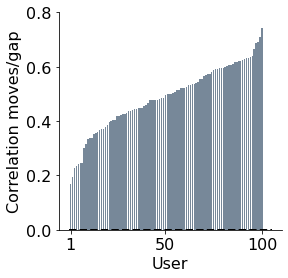

In [175]:
# Plot the correlations as a histogram
fig, ax = plt.subplots(figsize=(4,4))

ax.bar(np.arange(1,101),np.sort(corrs_movesgap), color='lightslategray')
ax.hlines(0,0,105,linewidth=2,linestyle='--',color='black')
ax.set_xlabel('User')
ax.set_ylabel('Correlation moves/gap')
# ax.set_xlim(-0.6,0.6)
ax.set_xticks([1,50,100])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
# ax.set_ylim(0,38)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('5B.png', format='png', dpi=1000,bbox_inches = 'tight')

In [147]:
idx12 = np.where((np.asarray(pieces) == 12) & (np.asarray(gaps) < 10))
rts12 = np.asarray(rts)[idx12]
gaps12 = np.asarray(gaps)[idx12]
st.spearmanr(gaps12, rts12)

SpearmanrResult(correlation=-0.19694857208132116, pvalue=6.269048865502798e-10)

In [148]:
idx18 = np.where((np.asarray(pieces) == 18) & (np.asarray(gaps) < 10))
rts18 = np.asarray(rts)[idx18]
gaps18 = np.asarray(gaps)[idx18]
st.spearmanr(gaps18, rts18)

SpearmanrResult(correlation=-0.2828443710351639, pvalue=7.651251052324619e-08)

In [149]:
idx24 = np.where((np.asarray(pieces) == 24) & (np.asarray(gaps) < 10))
rts24 = np.asarray(rts)[idx24]
gaps24 = np.asarray(gaps)[idx24]
st.spearmanr(gaps24, rts24)

SpearmanrResult(correlation=-0.32752694963961476, pvalue=3.5862489146110894e-05)

In [151]:
def regression(m,x,b):
    return m * x + b

slope12, intercept12 = np.polyfit(gaps12, np.log(rts12), 1)
slope18, intercept18 = np.polyfit(gaps18, np.log(rts18), 1)
slope24, intercept24 = np.polyfit(gaps24, np.log(rts24), 1)

In [160]:
print(slope12, intercept12)
print(slope18, intercept18)
print(slope24, intercept24)

-0.06606686295429397 1.148464877556297
-0.09009691631365309 1.3040636764834512
-0.13920678320585628 1.4273800019824014


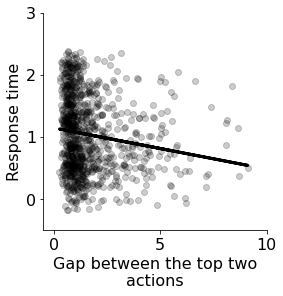

In [158]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))

plt.scatter(gaps12, np.log(rts12), color='black', alpha=0.2)
plt.plot(gaps12, regression(gaps12, slope12, intercept12),color='black',lw=3)
plt.xlabel('Gap between the top two\nactions')
plt.ylabel('Response time')
# plt.xscale('log')
# plt.yscale('log')
ax.set_xticks([0, 5, 10])
ax.set_yticks([0, 1, 2, 3])
# ax.set_xlim(-10,1000)
ax.set_xlim(-.5, 10)
ax.set_ylim(-.5, 3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.minorticks_off()

# plt.savefig('5C_left.png', format='png', dpi=1000,bbox_inches = 'tight')

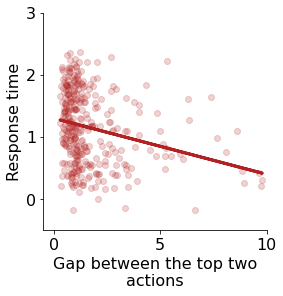

In [157]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))

plt.scatter(gaps18, np.log(rts18), color='firebrick', alpha=0.2)
plt.plot(gaps18, regression(gaps18, slope18, intercept18),color='firebrick',lw=3)
plt.xlabel('Gap between the top two\nactions')
plt.ylabel('Response time')
# plt.xscale('log')
# plt.yscale('log')
ax.set_xticks([0, 5, 10])
ax.set_yticks([0, 1, 2, 3])
# ax.set_xlim(-10,1000)
ax.set_xlim(-.5, 10)
ax.set_ylim(-.5, 3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.minorticks_off()

# plt.savefig('5C_middle.png', format='png', dpi=1000,bbox_inches = 'tight')

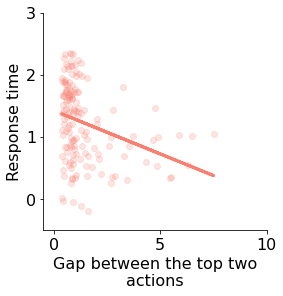

In [156]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))

plt.scatter(gaps24, np.log(rts24), color='salmon', alpha=0.2)
plt.plot(gaps24, regression(gaps24, slope24, intercept24),color='salmon',lw=3)
plt.xlabel('Gap between the top two\nactions')
plt.ylabel('Response time')
# plt.xscale('log')
# plt.yscale('log')
ax.set_xticks([0, 5, 10])
ax.set_yticks([0, 1, 2, 3])
# ax.set_xlim(-10,1000)
ax.set_xlim(-.5, 10)
ax.set_ylim(-.5, 3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.minorticks_off()

# plt.savefig('5C_right.png', format='png', dpi=1000,bbox_inches = 'tight')

In [141]:
# Compute rts/depth by move number
user_moves = np.zeros(36)
model_moves = np.zeros(36)
iteration_moves = np.zeros(36)
count = np.zeros(36)

for i in range(len(pieces)):
    idx = int(pieces[i])
    user_moves[idx] += rts[i]
    model_moves[idx] += depths[i]
    iteration_moves[idx] += iterations[i]
    count[idx] += 1

In [142]:
user_norm = st.zscore(user_moves[0::2]/count[0::2])
model_norm = st.zscore(model_moves[0::2]/count[0::2])
iterations_norm = st.zscore(iteration_moves[0::2]/count[0::2])

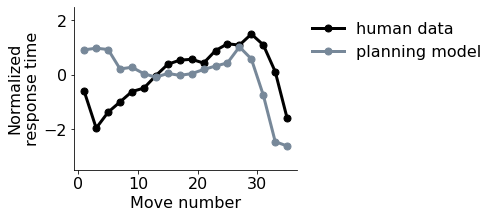

In [146]:
# Plot
fig, ax = plt.subplots(figsize=(4,3))
ax.set_ylim(-3.5, 2.5)
# ax.set_yticks([2,3,4,5])
ax.plot(np.arange(1,37,2), user_norm, color='black', marker='o', ms=7, lw=3, label='human data')
ax.plot(np.arange(1,37,2), iterations_norm, color='lightslategray', marker='o', ms=7, lw=3, label='planning model')
# ax.fill_between(np.arange(1,37,2), user-user_sem, user+user_sem, alpha=0.2, color='black')
ax.set_xlabel('Move number')
ax.set_ylabel('Normalized\nresponse time')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon = False, bbox_to_anchor=(1,1), loc='upper left')

# plt.savefig('6A.png', format='png', dpi=1000,bbox_inches = 'tight')